In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [9]:
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir /content/drive/MyDrive/HelmetProtection/part1/ --write_json ./output/ --display 0  --write_images output_images

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 463.571971 seconds.


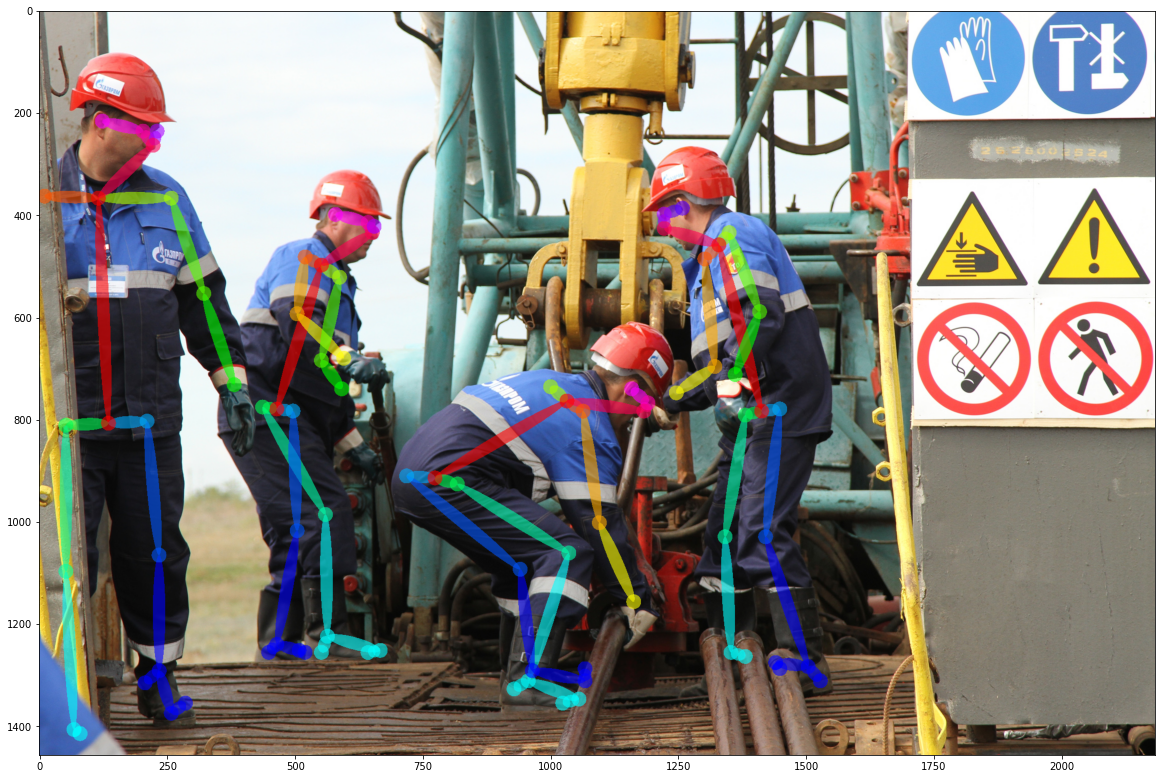

In [44]:
import cv2
import matplotlib.pyplot as plt

path = '/content/drive/MyDrive/HelmetProtection/part1/'
im = '1 (1).jpg'
#im = '201212211214492article-1.jpg'
#im = '5 (1).jpg'

img = cv2.imread(os.path.join(path,im))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

op_path = '/content/openpose/output_images'
op_im = ''.join(im.split('.')[:-1]) + '_rendered.png'

op_img = cv2.imread(os.path.join(op_path,op_im))
op_img = cv2.cvtColor(op_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(20)
plt.imshow(op_img, vmin = 0, vmax = 255)

[[0.7445459]]
[[0.6640857]]
[[0.79681015]]
[[0.7512113]]


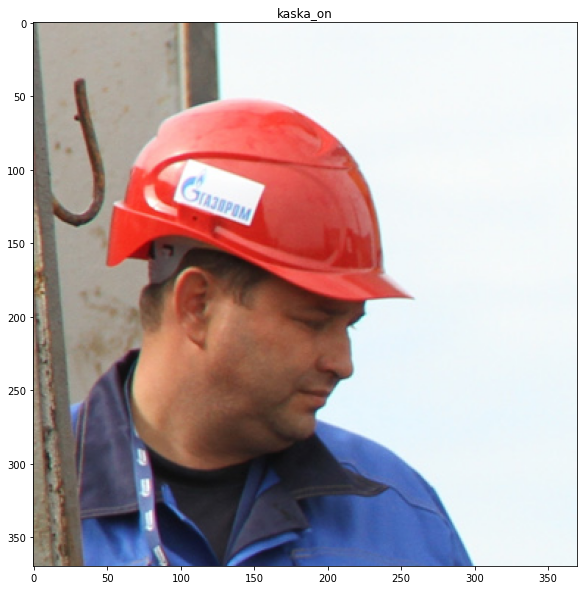

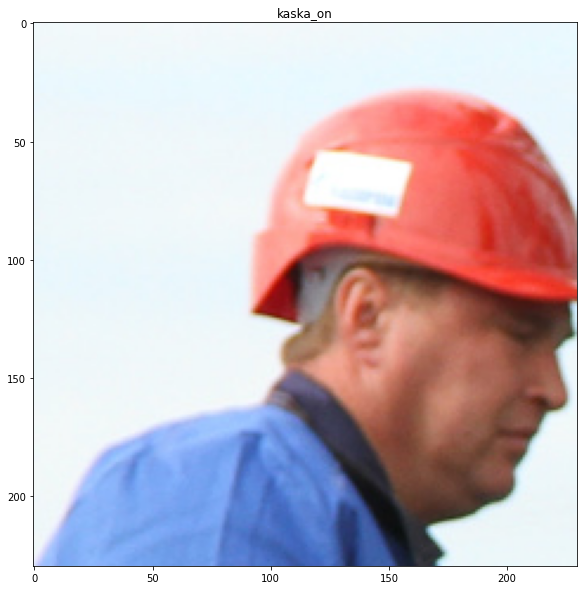

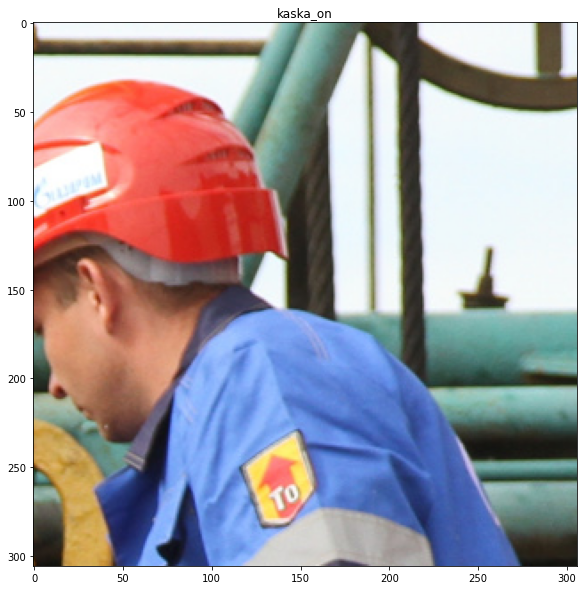

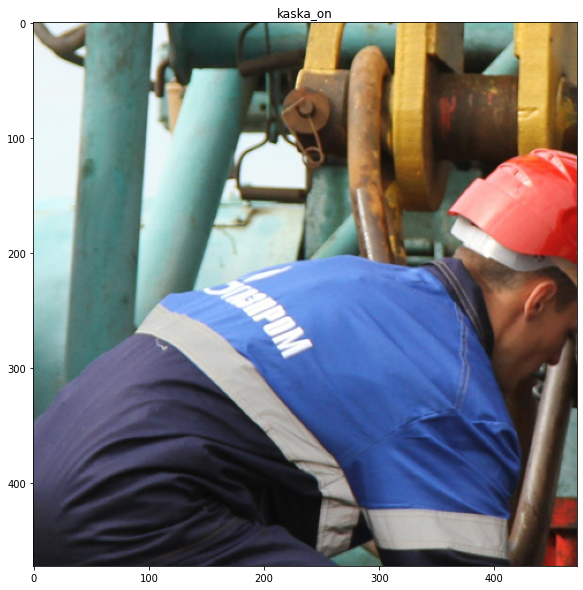

In [45]:
import json
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/HelmetProtection/model.h5')


dim = (224, 224)

path_js = '/content/openpose/output/'
js = ''.join(im.split('.')[:-1]) + '_keypoints.json'

with open(path_js + js, "r") as read_file:
  try:
    data = json.load(read_file)
  except:
    print('Error: Не удалось получить информацию о людях на изображении!')

for human in data['people']:

  i_list = human['pose_keypoints_2d'][0::3]
  j_list = human['pose_keypoints_2d'][1::3]

  i_min, i_max = int(min([x for x in i_list if x != 0])), int(max([x for x in i_list if x != 0]))
  j_min, j_max = int(min([x for x in j_list if x != 0])), int(max([x for x in j_list if x != 0]))


  W = i_max - i_min
  H = j_max - j_min

  r = int(W / 2)

  i = (i_min + i_max) // 2
  j = (j_min + j_max) // 2 - 5 * H // 10

  i1, j1 = max(0,i - r), max(0,j - r)
  i2, j2 = min(img.shape[1],i + r), min(img.shape[0],j + r)


  fig, ax = plt.subplots()
  fig.set_figwidth(10)
  fig.set_figheight(10)
  plt.imshow(img[j1:j2,i1:i2,:], vmin = 0, vmax = 255)

  resized_img = cv2.resize(img[j1:j2,i1:i2,:], dim, interpolation = cv2.INTER_AREA)
  exp_img = np.expand_dims(resized_img, axis = 0)
  pred = model.predict(exp_img)
  print(pred)
 
  if model.predict(exp_img)>0.5:
      ax.set(title='kaska_on')
  else:
      ax.set(title='kaska_off')
